In [1]:
import os
import cv2
import random
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nibabel as nib
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras import layers, models

In [2]:
img_path = '/kaggle/input/bloodvesseldata/images/images/JK01_26.04_DA3_16.png'
mask_path = '/kaggle/input/bloodvesseldata/masks/masks/JK01_26.04_DA3_16.png'
img = np.array(Image.open(img_path))
mask = np.array(Image.open(mask_path))
print(img.shape)
print(mask.shape)

(1920, 1703, 3)
(1920, 1703, 3)


In [3]:
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder (Contracting path)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    b = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    b = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(b)

    # Decoder (Expanding path)
    u4 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(b)
    u4 = layers.concatenate([u4, c4], axis=3)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    u3 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c5)
    u3 = layers.concatenate([u3, c3], axis=3)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u2 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c6)
    u2 = layers.concatenate([u2, c2], axis=3)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u1 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c7)
    u1 = layers.concatenate([u1, c1], axis=3)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Define input shape (height, width, channels)
input_shape = (256, 256, 3)  # Example: 256x256 RGB images
model = unet_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      4,719,104 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 34,513,345 (131.66 MB)

 Trainable params: 34,513,345 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# lists of directories with studies
DIRECTORY = "/kaggle/input/bloodvesseldata/images/images"

file_names = [f for f in os.listdir(DIRECTORY) if os.path.isfile(os.path.join(DIRECTORY, f))]

train_and_test_ids = file_names

train_ids, test_ids = train_test_split(train_and_test_ids,test_size=0.2)

print(test_ids)


# Load the Excel file (specify sheet name if needed)
file_path = '/kaggle/input/bloodvesseldata/BASE_20240410.xlsx'
info_df = pd.read_excel(file_path, sheet_name='Sheet1')

# Replace 'Name' with the actual column name, and 'John' with the name you're searching
result = info_df[info_df['Original image'] == "JK_04_2904AА3_20.1.png"]

# Display the result
print(result["Average vessel diameter (μm)"].values[0])



suba = "А"
subx = "х"
subc = "с"

['MA19_99L3_6_�10.png', 'JK_04_2604AA4_5.3.png', 'JK03_0305_EA4_14.png', 'JK03_3004_AA3_7.3.png', 'MA19_99L4_14_�10.png', 'MA19_76L3_5_�10.png', 'MA3_92L3_6_�10.png', 'MA19_96L4_11_�10.png', 'MA6_61L4_4_�10.png', 'MA4_46L3_18_�10.png', 'MA6_88L4_1_�10.png', 'JK03_3004_AA3_37.png', 'JK_02_0305DA3_13.png', 'VZ3_105_32_x10.png', 'MA6_94L4_2_�10.png', 'VZ0_71_11__�10.png', 'MA2_77L4_2_�10.png', 'MA4_75L3_7_�10.png', 'MA4_28L3_8_�10.png', 'JK_05_2904CA4_24.png', 'JK_05_2904CA4_30.png', 'MA4_75L3_6_�10.png', 'MA19_14L4_3_�10.png', 'MA5_81L3_6_�10.png', 'VZ0_71_9__�10.png', 'JK06_2704_AA3_28.png', 'JK_02_2604_AA4_40.png', 'JK_04_0305AA4_4.png', 'MA19_76L3_10_�10.png', 'JK_04_2604AA4_7.png', 'MA19_76L4_1_�10.png', 'MA3_30L3_14_�10.png', 'JK_04_2604AA4_5.2.png', 'MA6_88L4_6.2_�10.png', 'VZ4_6_15_x10.png', 'JK_04_2904A�3_6.2.png', 'VZ3_10.1_37_x10.png', 'MA19_99L4_5_�10.png', 'MA19_14L4_11_�10.png', 'JK_02_0305DA4_5.2.png', 'VN4_14L3_5.png', 'MA19_14L3_6_�10.png', 'JK03_0305_AA3_6.png', 'MA1_3L3

In [5]:
# Define paths for images and masks
image_dir = '/kaggle/input/bloodvesseldata/images/images'
mask_dir = '/kaggle/input/bloodvesseldata/masks/masks'

# Get the list of image and mask filenames
image_filenames = sorted(os.listdir(image_dir))  # Ensure sorting to match images with masks
mask_filenames = sorted(os.listdir(mask_dir))

# Define a function to load and preprocess images
def load_image(image_path, target_size=(256, 256)):
    img = Image.open(image_path).convert('RGB')  # Convert to RGB
    img = img.resize(target_size, Image.Resampling.LANCZOS)  # Resize to target size
    return np.array(img) / 255.0  # Normalize to [0, 1]

# Define a function to load and preprocess masks
def load_mask(mask_path, target_size=(256, 256)):
    mask = Image.open(mask_path).convert('L')  # Convert to grayscale ('L' mode)
    mask = mask.resize(target_size, Image.Resampling.LANCZOS)  # Resize to target size
    return np.array(mask) / 255.0  # Normalize to [0, 1]

# Initialize lists to store images and masks
X_train = []
y_train = []
X_test = []
y_test = []

# Loop through all the image and mask filenames and load them for the training set
for img_id in train_ids:
    img_path = os.path.join(image_dir, img_id)
    mask_path = os.path.join(mask_dir, img_id)
    
    # Load and preprocess the image and mask
    img = load_image(img_path)
    mask = load_mask(mask_path)
    
    # Append the loaded image and mask to the lists
    X_train.append(img)
    y_train.append(mask)

# Loop through all the image and mask filenames and load them for the test set
for img_id in test_ids:
    img_path = os.path.join(image_dir, img_id)
    mask_path = os.path.join(mask_dir, img_id)
    
    # Load and preprocess the image and mask
    img = load_image(img_path)
    mask = load_mask(mask_path)
    
    # Append the loaded image and mask to the lists
    X_test.append(img)
    y_test.append(mask)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure that y_train has the correct shape for binary segmentation (height, width, 1)
y_train = np.expand_dims(y_train, axis=-1)  # Add a channel dimension
y_test = np.expand_dims(y_test, axis=-1)

# Print the shape of the arrays to verify
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (487, 256, 256, 3)
y_train shape: (487, 256, 256, 1)
X_test shape: (122, 256, 256, 3)
y_test shape: (122, 256, 256, 1)


In [6]:
# Example: Load your dataset (replace with your actual data loading process)
# X_train, y_train should be numpy arrays of shape (num_samples, height, width, channels)

# Example: Load your dataset here (ensure it's preprocessed and scaled properly)
# X_train, y_train = load_data()  # Load your images and masks

# Train the model
model.fit(X_train, y_train, batch_size=16, epochs=30, validation_split=0.1)


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9674 - loss: 0.6107 - val_accuracy: 0.9729 - val_loss: 0.1204
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 390ms/step - accuracy: 0.9668 - loss: 0.1171 - val_accuracy: 0.9729 - val_loss: 0.1043
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 389ms/step - accuracy: 0.9670 - loss: 0.1169 - val_accuracy: 0.9729 - val_loss: 0.0865
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 390ms/step - accuracy: 0.9651 - loss: 0.1059 - val_accuracy: 0.9729 - val_loss: 0.0782
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 390ms/step - accuracy: 0.9670 - loss: 0.0900 - val_accuracy: 0.9729 - val_loss: 0.0895
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 391ms/step - accuracy: 0.9641 - loss: 0.0852 - val_accuracy: 0.9729 - val_loss: 0.0676
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 391ms/step - accuracy: 0.9620 - loss: 0.0792 - val_accuracy: 0.9729 - val_loss: 0.0671
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 392ms/step - accuracy: 0.9642 - loss: 0.0751 - val_accurac

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


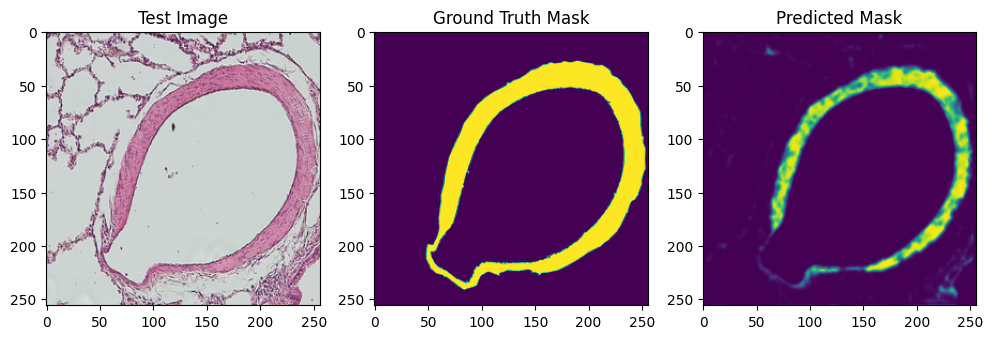

0.764945361058231


In [7]:
id = 'JK_02_0305DA3_13.png'

img = load_image(os.path.join(image_dir, id))
test = []
test.append(img)
test = np.array(test)

msk = load_mask(os.path.join(mask_dir, id))
test_msk = []
test_msk.append(msk)
test_msk = np.array(test_msk)

# Example: Predict on a new image
# X_test is the test dataset
predictions = model.predict(test)

# Plot the first image, mask, and prediction
plt.figure(figsize=(12, 4))


plt.subplot(1, 3, 1)
plt.imshow(test[0])
plt.title('Test Image')

plt.subplot(1, 3, 2)
plt.imshow(test_msk[0])
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(predictions[0])
plt.title('Predicted Mask')

plt.show()


def dice_coefficient(pred_mask, true_mask, smooth=1e-6):
    """
    Compute Dice Coefficient between predicted and ground truth masks.

    Args:
        pred_mask (np.ndarray): Binary predicted mask (0 or 1).
        true_mask (np.ndarray): Binary ground truth mask (0 or 1).
        smooth (float): Small constant to avoid division by zero.

    Returns:
        float: Dice coefficient (0 to 1).
    """
    pred_flat = pred_mask.flatten()
    true_flat = true_mask.flatten()
    
    intersection = np.sum(pred_flat * true_flat)
    return (2. * intersection + smooth) / (np.sum(pred_flat) + np.sum(true_flat) + smooth)

# Convert to binary masks using a threshold (e.g., 0.5)
pred_bin = (predictions[0] > 0.1).astype(np.uint8)
true_bin = (test_msk[0] > 0.01).astype(np.uint8)

dice = dice_coefficient(pred_bin, true_bin)


print(dice)

In [8]:
results = []

for img_id in test_ids:
    img = load_image(os.path.join(image_dir, img_id))
    test = []
    test.append(img)
    test = np.array(test)
    
    msk = load_mask(os.path.join(mask_dir, img_id))
    test_msk = []
    test_msk.append(msk)
    test_msk = np.array(test_msk)
    
    # Example: Predict on a new image
    # X_test is the test dataset
    predictions = model.predict(test)

    print(img_id)
    if(img_id[0] == "J" and "�" in img_id):
        img_id = img_id.replace("�", suba)
    elif(img_id[0] == "V" and img_id.count("�") == 2):
        img_id = img_id.replace("�", subc, 1)
        img_id = img_id.replace("�", subx, 2)   
    elif((img_id[0] == "M" or img_id[0] == "V") and "�" in img_id):
        img_id = img_id.replace("�", subx)   
    
    row = info_df[info_df['Original image'] == img_id]
    diameter = row["Average vessel diameter (μm)"].values[0]

    # Convert to binary masks using a threshold (e.g., 0.5)
    pred_bin = (predictions[0] > 0.1).astype(np.uint8)
    true_bin = (test_msk[0] > 0.01).astype(np.uint8)
    
    dice = dice_coefficient(pred_bin, true_bin)

    results.append([img_id, dice, diameter])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MA19_99L3_6_�10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
JK_04_2604AA4_5.3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
JK03_0305_EA4_14.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
JK03_3004_AA3_7.3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MA19_99L4_14_�10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MA19_76L3_5_�10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MA3_92L3_6_�10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MA19_96L4_11_�10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MA6_61L4_4_�10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MA4_46L3_18_�10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MA6_88L4_1_�10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
JK03_3004_AA3_37.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
JK_02_0305DA3_13.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
VZ3_105_32_x10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MA6_94L4_2_�10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
VZ0_71_11__�10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MA2_77L4_2_�10.png
1/1 ━━━━━━━━

In [9]:
print(results)

[['MA19_99L3_6_х10.png', 0.18802462272634324, 94.35811], ['JK_04_2604AA4_5.3.png', 0.11584327237505404, 38.390462], ['JK03_0305_EA4_14.png', 0.4783379783434665, 164.1088075], ['JK03_3004_AA3_7.3.png', 0.6452009529205256, 144.9591], ['MA19_99L4_14_х10.png', 0.028243601916819412, 112.21969], ['MA19_76L3_5_х10.png', 0.615832928792699, 116.34238], ['MA3_92L3_6_х10.png', 0.03149606451732903, 68.83426], ['MA19_96L4_11_х10.png', 0.32367149840136294, 77.831545], ['MA6_61L4_4_х10.png', 0.2693069314165278, 89.244815], ['MA4_46L3_18_х10.png', 0.05808080927009999, 94.431425], ['MA6_88L4_1_х10.png', 2.0833333289930555e-09, 56.963368], ['JK03_3004_AA3_37.png', 0.00796812792918631, 284.499369], ['JK_02_0305DA3_13.png', 0.764945361058231, 541.8280285], ['VZ3_105_32_x10.png', 1.2562814054569328e-09, 108.84539], ['MA6_94L4_2_х10.png', 0.011764707044982697, 71.527819], ['VZ0_71_11__х10.png', 0.04060638886835322, 536.18], ['MA2_77L4_2_х10.png', 0.032807180738840244, 160.87016], ['MA4_75L3_7_х10.png', 0.17

In [10]:
avg1 = 0
num1 = 0
avg2 = 0
num2 = 0
avg3 = 0
num3 = 0
avg4 = 0
num4 = 0
avg5 = 0
num5 = 0
avg6 = 0
num6 = 0
for row in results:
    if(row[2] >= 0 and row[2] < 100):
        avg1 += row[1]
        num1 += 1
    if(row[2] >= 100 and row[2] < 200):
        avg2 += row[1]
        num2 += 1
    elif(row[2] >= 200 and row[2] < 300):
        avg3 += row[1]
        num3 += 1
    elif(row[2] >= 300 and row[2] < 400):
        avg4 += row[1]
        num4 += 1
    elif(row[2] >= 400 and row[2] < 500):
        avg5 += row[1]
        num5 += 1
    elif(row[2] >= 500):
        avg6 += row[1]
        num6 += 1
avg1 /= num1
avg2 /= num2
avg3 /= num3
avg4 /= num4
avg5 /= num5
avg6 /= num6
print(avg1, avg2, avg3, avg4, avg5, avg6)

0.14441156570964633 0.17212150484658825 0.34639254600161473 0.40003305751543033 0.7331297800096609 0.4027758749632921


In [11]:
data = [
    ["Name", "Dice", "Diameter"],
]

# Convert to DataFrame (use first row as header)
df = pd.DataFrame(results[0:], columns=data[0])
df.to_csv("/kaggle/working/results.csv", index=False)


4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 7s/step


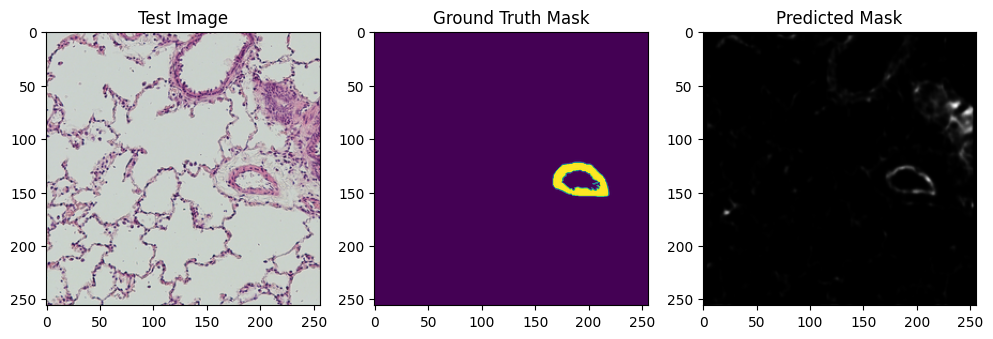

In [12]:
# Example: Predict on a new image
# X_test is the test dataset
predictions = model.predict(X_test)

# Plot the first image, mask, and prediction
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(X_test[0])
plt.title('Test Image')

plt.subplot(1, 3, 2)
plt.imshow(y_test[0])
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(predictions[0].squeeze(), cmap='gray')
plt.title('Predicted Mask')

plt.show()

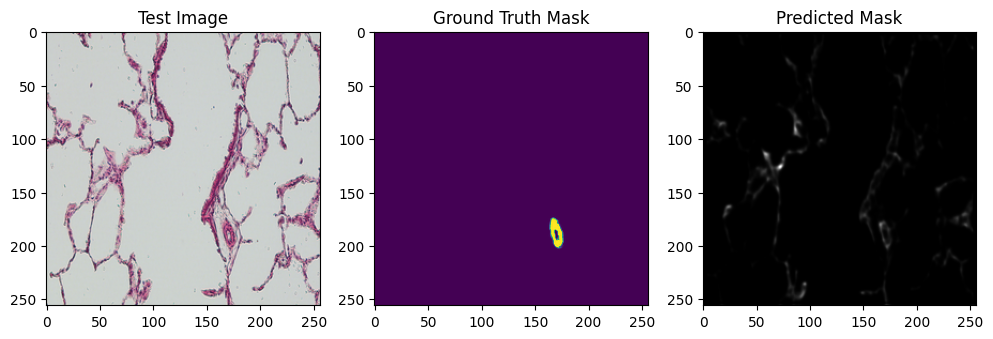

In [13]:
# Plot the first image, mask, and prediction
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(X_test[1])
plt.title('Test Image')

plt.subplot(1, 3, 2)
plt.imshow(y_test[1])
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(predictions[1].squeeze(), cmap='gray')
plt.title('Predicted Mask')

plt.show()